REBOUND RV and Plotting function
====================================

In [1]:
import stability_functions as sf
import numpy as np
from numpy.random import normal, seed, uniform
import os
import time
import sys
import rebound
import mr_forecast as mr
import numpy.random as rd
import radvel
import corner
import copy
import scipy
import pandas as pd
from scipy import optimize
from radvel.plot import orbit_plots
# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/radvel/gp.py:33: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  Try installing celerite using 'pip install celerite'", ImportWarning)


In [2]:
seconds_p_day = 86400
days_p_year = 365.25
meters_p_AU = 149597870700
earth_mass_2_solar_mass = 0.000003003
year_p_reboundtime = 1 / (2 * np.pi)

# Convenient function for plotting fits
def plot_results(like):
    ti = np.linspace(np.min(t), np.max(t), 1000)
    fig = plt.gcf()
    plt.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plt.plot(ti, like.model(ti))
    plt.xlabel('Time')
    plt.ylabel('RV')
    plt.draw()

#Radial basis function kernel(aka squared exonential, ~gaussian)
def SE_kernel(hyperparameters, dif_sq):
    
    kernel_length = hyperparameters
    return np.exp(-dif_sq/(2*kernel_length**2))

#Periodic kernel
def periodic_kernel(hyperparameters, dif):
    
    kernel_length, kernel_period = hyperparameters
    return np.exp(-2*np.sin(np.pi*dif/kernel_period)**2/(kernel_length**2))

#Creating a custom kernel (possibly by adding and multiplying other kernels?)
def kernel(hyperparameters,x1,x2):
        
    #converting inputs to arrays and finding their squared differences
    x1a = np.array(x1)
    x2a = np.array(x2)
    dif_vec = x1a - x2a
    dif_sq = np.dot(dif_vec, dif_vec)
    dif = np.sqrt(dif_sq)
    
    return hyperparameters[0] ** 2 * periodic_kernel(hyperparameters[1:3], dif) * SE_kernel(hyperparameters[3:4], dif_sq)

def covariance(x1list, x2list, hyperparameters):
    K = np.zeros((len(x1list), len(x2list)))
    for i, x1 in enumerate(x1list):
        for j, x2 in enumerate(x2list):
            K[i, j] = kernel(hyperparameters, x1, x2)
    return K

Getting RVs
====================================

Inserting planets from Vanderburg et al. 2019

https://arxiv.org/abs/1905.05193

In [3]:
sim_nums = np.array([269, 621, 668, 645, 798, 644])
sim_num = sim_nums[0]

system = "HR858"
out_dir = os.getcwd()+"/output/"+system+"/"
name = out_dir+system+"_start_"+str(sim_num)+".bin"

print("simulation archive:", name)
sim = rebound.SimulationArchive(name)[0]
rv_sim = rebound.SimulationArchive(name)[0]

simulation archive: /storage/work/c/cjg66/Dan_research/Stability-Priors/output/HR858/HR858_start_269.bin


In [4]:
seed(3)
n_meas = 200
t = 0.5 * np.sort(rd.rand(n_meas))
syn_rv = sf.rebound_rvs(t, rv_sim)

errs = np.array([10, 3, 1, 0.3, 0.1])
if sys.argv[1] != "-f":
    err_ind = int(sys.argv[1])
else:
    err_ind = -1
errvel = errs[err_ind]

if False
    # hyperparameters = amp, P_len, P_P, SE_len
    K = covariance(t, t, np.array([0.5, 1, 7 / days_p_year, 15 / days_p_year]))
    L = np.linalg.cholesky(K + 1e-10 * np.eye(n_meas))
    stellar = np.matmul(L, normal(size=n_meas)) 
    jitter = np.std(stellar)
else:
    jitter = 1
    stellar = jitter * rd.randn(n_meas)
    
syn_rv += rd.randn(n_meas) * errvel + stellar
print("jitter value:", jitter)

jitter value: 0.5960929620296838


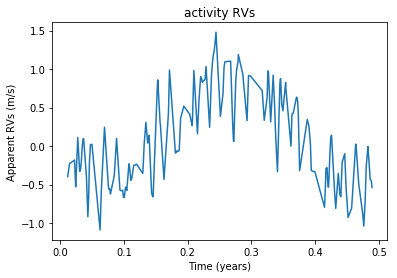

In [5]:
plt.plot(t, stellar)
plt.xlabel("Time (years)")
plt.ylabel("Apparent RVs (m/s)")
plt.title("activity RVs")
plt.show()
plt.savefig("figs/activityrv_%d.png"%err_ind, bbox_inches="tight")
plt.close(fig="all")

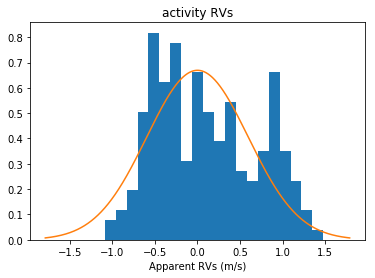

In [6]:
plt.hist(stellar, density=True, bins = n_meas//10)
x = np.linspace(-3 * jitter, 3 * jitter, 1000)
plt.plot(x, scipy.stats.norm.pdf(x, scale=jitter))
plt.xlabel("Apparent RVs (m/s)")
plt.title("activity RVs")
plt.show()
plt.savefig("figs/activityhist_%d.png"%err_ind, bbox_inches="tight")
plt.close(fig="all")

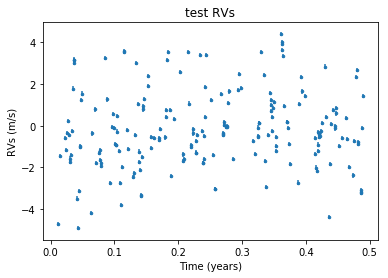

In [7]:
plt.errorbar(t, syn_rv, yerr=errvel, fmt='.')
plt.xlabel("Time (years)")
plt.ylabel("RVs (m/s)")
plt.title("test RVs")
plt.show()
plt.savefig("figs/totalrvs_%d.png"%err_ind, bbox_inches="tight")
plt.close(fig="all")

In [8]:
# Ps = np.array([sim.particles[i+1].P for i in range(3)]) * (days_p_year * year_p_reboundtime)
# es = np.array([sim.particles[i+1].e for i in range(3)])
# Mstar = sim.particles[0].m
# ms = np.array([sim.particles[i+1].m for i in range(3)]) / earth_mass_2_solar_mass
# incs = np.array([sim.particles[i+1].inc for i in range(3)]) + np.pi/2
# Ks = sf.VSA(Ps / days_p_year, Mstar, ms, es, incs)
Ps = np.array([3.58599, 5.97293, 11.2300])
es = np.array([0.1 for i in range(3)])
Mstar = sim.particles[0].m
ms = np.array([mr.Rstat2M(2.085, 0.066)[0], mr.Rstat2M(1.939, 0.069)[0], mr.Rstat2M(2.164, 0.085)[0]])
incs = np.pi / 180 * np.array([85.5, 86.23, 87.43])
Ks = sf.VSA(Ps / days_p_year, Mstar, ms, es, incs)
print("initial Ks:", Ks)

initial Ks: [2.05256676 1.56242161 1.49612532]


Creating radvel model
====================================

In [9]:
# radvel uses days
t *= days_p_year

In [10]:
params = radvel.Parameters(3, basis='per tc secosw sesinw k')
params['per1'] = radvel.Parameter(value=Ps[0])
params['tc1'] = radvel.Parameter(value= 2458409.18969)
params['secosw1'] = radvel.Parameter(value=np.sqrt(es[0]))
params['sesinw1'] = radvel.Parameter(value=0)
params['k1'] = radvel.Parameter(value=Ks[0])

params['per2'] = radvel.Parameter(value=Ps[1])
params['tc2'] = radvel.Parameter(value=2458415.6344)
params['secosw2'] = radvel.Parameter(value=np.sqrt(es[1]))
params['sesinw2'] = radvel.Parameter(value=0)
params['k2'] = radvel.Parameter(value=Ks[1])

params['per3'] = radvel.Parameter(value=Ps[2])
params['tc3'] = radvel.Parameter(value=2458409.7328)
params['secosw3'] = radvel.Parameter(value=np.sqrt(es[2]))
params['sesinw3'] = radvel.Parameter(value=0)
params['k3'] = radvel.Parameter(value=Ks[2])

# params['dvdt'] = radvel.Parameter(value=0)
# params['curv'] = radvel.Parameter(value=0)

rv_mod = radvel.RVModel(params)

Generate likelihood
====================================

In [11]:
like_syn = radvel.likelihood.RVLikelihood(rv_mod, t, syn_rv, np.zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=jitter)

# like_syn.params['jit'].vary = False # Don't vary jitter
# like_syn.params['per1'].vary = False # Don't vary period
# like_syn.params['per2'].vary = False # Don't vary period
# like_syn.params['per3'].vary = False # Don't vary period
like_syn.params['dvdt'].vary = False # Don't vary dvdt
like_syn.params['curv'].vary = False # Don't vary curvature
like_syn.params['gamma'].vary = False # Don't vary gamma
print(like_syn)

parameter                     value      vary
per1                        3.58599       True
tc1                         8409.19       True
secosw1                    0.316228       True
sesinw1                           0       True
k1                          2.05257       True
per2                        5.97293       True
tc2                         8415.63       True
secosw2                    0.316228       True
sesinw2                           0       True
k2                          1.56242       True
per3                          11.23       True
tc3                         8409.73       True
secosw3                    0.316228       True
sesinw3                           0       True
k3                          1.49613       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                        0.596093       True



Get MLE just using data
====================================

In [12]:
# Plot initial model
plot_results(like_syn)
plt.savefig("figs/beforeMLE_%d.png"%err_ind, bbox_inches="tight")
plt.close(fig="all")

In [13]:
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead')
# res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B')
# print(res)
print(like_syn)
plot_results(like_syn) # plot best fit model
plt.savefig("figs/afterMLE_%d.png"%err_ind, bbox_inches="tight")
plt.close(fig="all")

parameter                     value      vary
per1                        3.59673       True
tc1                        -14670.6       True
secosw1                    0.321699       True
sesinw1                -4.45617e-06       True
k1                          2.05501       True
per2                        6.00196       True
tc2                         66397.8       True
secosw2                    0.302115       True
sesinw2                 3.62792e-05       True
k2                          1.58418       True
per3                        11.5755       True
tc3                         71965.2       True
secosw3                    0.310682       True
sesinw3                -5.21322e-05       True
k3                          1.45539       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                        0.605972       True



Initialize posterior and add priors
====================================

In [14]:
post = radvel.posterior.Posterior(like_syn)

post.priors += [radvel.prior.EccentricityPrior(3, 0.3)]

print("Before fitting\n")
print(post)

Before fitting

parameter                     value      vary
per1                        3.59673       True
tc1                        -14670.6       True
secosw1                    0.321699       True
sesinw1                -4.45617e-06       True
k1                          2.05501       True
per2                        6.00196       True
tc2                         66397.8       True
secosw2                    0.302115       True
sesinw2                 3.62792e-05       True
k2                          1.58418       True
per3                        11.5755       True
tc3                         71965.2       True
secosw3                    0.310682       True
sesinw3                -5.21322e-05       True
k3                          1.45539       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                        0.605972       True

Priors
------
e1 constrained to be < 0.3
e2 

Fit based on priors
====================================

In [15]:
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
# plot_results(post.likelihood)
# plt.savefig("afterpriors_%d.png"%err_ind, bbox_inches="tight")
print("After fitting\n")
print(post)

After fitting

parameter                     value      vary
per1                        3.59691       True
tc1                        -14549.3       True
secosw1                    0.375774       True
sesinw1                -5.64644e-06       True
k1                          2.05729       True
per2                        6.00205       True
tc2                         66433.4       True
secosw2                    0.201298       True
sesinw2                 1.89003e-05       True
k2                          1.43189       True
per3                        11.5761       True
tc3                         72110.3       True
secosw3                     0.36456       True
sesinw3                -5.25493e-05       True
k3                         0.489619       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                         1.00747       True

Priors
------
e1 constrained to be < 0.3
e2 c

In [16]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()
plt.savefig("figs/afterpriors_%d.png"%err_ind, bbox_inches="tight")
plt.close(fig="all")

No handles with labels found to put in legend.


Use mcmc to sample the posterior distribution and corner to visualize
========================

In [17]:
df = radvel.mcmc(post,nwalkers=20,nrun=1000)
df.to_pickle("mcmc/mcmc_%d.pkl"%err_ind)
# df = pd.read_pickle("figs/mcmc_%d.pkl"%err_ind)

12800/256000 (5.0%) steps complete; Running 9164.62 steps/s; Mean acceptance rate = 9.8%; Min Tz = 1746.2; Max G-R = 1.016      
Discarding burn-in now that the chains are marginally well-mixed

256000/256000 (100.0%) steps complete; Running 8451.99 steps/s; Mean acceptance rate = 1.1%; Min Tz = 951.0; Max G-R = 1.031      

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


In [18]:
niter = len(df)
labels = [k for k in post.params.keys() if post.params[k].vary]

# fig = corner.corner(
#     df[labels],
#     labels=labels,
#     truths=[truths[k].value for k in labels ],
#     quantiles=[0.15,0.85],
#     plot_datapoints=False,
#     smooth=True,
#     bins=20
#     )
fig = corner.corner(
    df[labels],
    labels=labels,
    quantiles=[0.15,0.85],
    plot_datapoints=False,
    smooth=True,
    bins=20.
    )
plt.savefig("figs/corner_%d.png"%err_ind, bbox_inches="tight")
plt.close(fig="all")

In [19]:
for i in range(len(es)):
    print("original e%d: "%(i+1), es[i])
    mcmc = df["sesinw%d"%(i+1)]**2 + df["secosw%d"%(i+1)]**2
    med = np.median(mcmc)
    print("median mcmc e%d: "%(i+1), med)
    print("mean mcmc e%d: "%(i+1), np.mean(mcmc))
    print("std mcmc e%d: "%(i+1), np.std(mcmc))
    print("-----------------------------------")
    plt.figure()
    plt.hist(mcmc, density=True, bins = niter//1000)
    ax = plt.subplot(111)
    ax.axvline(x=es[i], color="black", linewidth=5)
    ax.axvline(x=med, color="orange", linewidth=4)
    ax.axvline(x=np.quantile(mcmc, 0.025), color="orange", linewidth=2)
    ax.axvline(x=np.quantile(mcmc, 0.975), color="orange", linewidth=2)
    plt.savefig("figs/e%d_%d.png"%(i, err_ind), bbox_inches="tight")
    plt.close(fig="all")

original e1:  0.1
median mcmc e1:  0.1520506598655948
mean mcmc e1:  0.15058161472194198
std mcmc e1:  0.04441245108002276
-----------------------------------
original e2:  0.1
median mcmc e2:  0.04512164500179941
mean mcmc e2:  0.04740730441915608
std mcmc e2:  0.015883062080457245
-----------------------------------
original e3:  0.1
median mcmc e3:  0.14995586100229058
mean mcmc e3:  0.15490349889438676
std mcmc e3:  0.04223168174931157
-----------------------------------


In [20]:
for i in range(len(Ks)):
    print("original k%d: "%(i+1), Ks[i])
    mcmc = df["k%d"%(i+1)]
    med = np.median(mcmc)
    print("median mcmc k%d: "%(i+1), np.median(mcmc))
    print("mean mcmc k%d: "%(i+1), np.mean(mcmc))
    print("std mcmc k%d: "%(i+1), np.std(mcmc))
    print("-----------------------------------")
    plt.figure()
    plt.hist(mcmc, density=True, bins = niter//1000)
    ax = plt.subplot(111)
    ax.axvline(x=Ks[i], color="black", linewidth=5)
    ax.axvline(x=med, color="orange", linewidth=4)
    ax.axvline(x=np.quantile(mcmc, 0.025), color="orange", linewidth=2)
    ax.axvline(x=np.quantile(mcmc, 0.975), color="orange", linewidth=2)
    plt.savefig("figs/K%d_%d.png"%(i, err_ind), bbox_inches="tight")
    plt.close(fig="all")

original k1:  2.052566761357897
median mcmc k1:  2.0620135790949816
mean mcmc k1:  2.0176698505689576
std mcmc k1:  0.2604491657997398
-----------------------------------
original k2:  1.5624216139959615
median mcmc k2:  1.526614572128478
mean mcmc k2:  1.5436675747446145
std mcmc k2:  0.1692627160562482
-----------------------------------
original k3:  1.496125320495595
median mcmc k3:  0.5107793722629645
mean mcmc k3:  0.5069596990243317
std mcmc k3:  0.08328678089900024
-----------------------------------
